---
#### Train
---

In [4]:
import pandas as pd
import os
import numpy as np
import time
import pickle
import warnings
from datetime import datetime
from keras.models import load_model
from keras.models import Sequential
from keras.layers import Dense, LSTM, BatchNormalization, Dropout, Conv1D, GlobalMaxPool1D, SimpleRNN
from keras import backend as K
from keras.wrappers.scikit_learn import KerasClassifier
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.utils import np_utils
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import IsolationForest
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score

---
#### 일단 네이블 통해 받은 데이터로 훈련을 한다.
---

In [5]:
ct = pd.read_csv('training-data-Slice01-20200118.csv')

In [6]:
ct

,SLICE,DATETIME,UPLINK_THROUGHPUT,DNLINK_THROUGHPUT,ACTIVE_USER
0,Slice01,2020-01-18T00:00:00,21690157,244798764,2556
1,Slice01,2020-01-18T00:05:00,23303153,234799993,2413
2,Slice01,2020-01-18T00:10:00,31590655,276907261,2463
3,Slice01,2020-01-18T00:15:00,19792626,235009752,2427
4,Slice01,2020-01-18T00:20:00,21312551,258244413,2373
...,...,...,...,...,...
687,Slice01,2020-01-20T09:40:00,59452828,625167856,3340
688,Slice01,2020-01-20T09:45:00,44974454,580920172,3840
689,Slice01,2020-01-20T09:50:00,48384076,477607952,3589
690,Slice01,2020-01-20T09:55:00,47639870,420845695,3145


In [26]:
import numpy as np
def create_dataset(signal_data, look_back = 144):
    dataX, dataY = [], []
    for i in range(len(signal_data)-156):
        dataX.append(signal_data[i:(i+look_back), 0])
        dataY.append(signal_data[(i + look_back):(i+156), 0])
    return np.array(dataX), np.array(dataY)

look_back = 144 ## 하루. 

train = ct[['UPLINK_THROUGHPUT']].values.reshape(-1,1)
x_train, y_train = create_dataset(train, look_back)

x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

model = Sequential()
model.add(SimpleRNN(144, return_sequences= True))
model.add(BatchNormalization())
model.add(SimpleRNN(144))
model.add(Dense(12, activation = 'linear'))
model.compile(loss='mean_squared_error', optimizer='adam')

# earlyStopping = EarlyStopping(monitor='val_loss', patience=2, verbose=1, mode='min')
# mcp_save = ModelCheckpoint('/data01/CSB/CSB_Jupyter/PROBE/Pyfile/CSB-Modelling/10월16일/TANGO/best_model.hdf5', save_best_only=True, monitor='val_loss', mode='min')

hist = model.fit(x_train/1e7, y_train/1e7, epochs=10, batch_size = 2)

Epoch 1/10
536/536 [==============================] - 34s 64ms/step - loss: 5.1156
Epoch 2/10
536/536 [==============================] - 34s 64ms/step - loss: 1.1264
Epoch 3/10
536/536 [==============================] - 32s 61ms/step - loss: 0.9395
Epoch 4/10
536/536 [==============================] - 32s 59ms/step - loss: 0.9215
Epoch 5/10
536/536 [==============================] - 32s 60ms/step - loss: 0.8441
Epoch 6/10
536/536 [==============================] - 34s 63ms/step - loss: 0.8109
Epoch 7/10
536/536 [==============================] - 33s 62ms/step - loss: 0.8147
Epoch 8/10
536/536 [==============================] - 34s 63ms/step - loss: 0.7891
Epoch 9/10
536/536 [==============================] - 33s 62ms/step - loss: 0.7405
Epoch 10/10
536/536 [==============================] - 35s 65ms/step - loss: 0.7914


#### model 저장

In [38]:
model.save('Slice01-prediction-uplink-throughput.h5')

#### 모델 제대로 돌아가는지 test 용

In [34]:
prediction = ct[['UPLINK_THROUGHPUT']][0:144].values
    
    
result = model.predict(np.reshape(prediction,(1,144,1))/1e7)*1e7

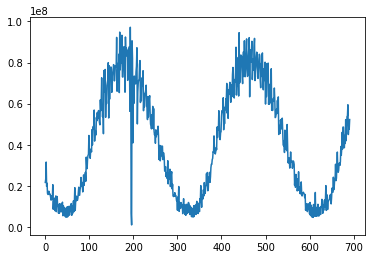

In [35]:
plt.plot(ct[['UPLINK_THROUGHPUT']])

In [23]:
ct[['UPLINK_THROUGHPUT']]

,UPLINK_THROUGHPUT
0,21690157
1,23303153
2,31590655
3,19792626
4,21312551
...,...
687,59452828
688,44974454
689,48384076
690,47639870


In [36]:
test = pd.DataFrame(result[0])
test.columns =['UPLINK_THROUGHPUT']

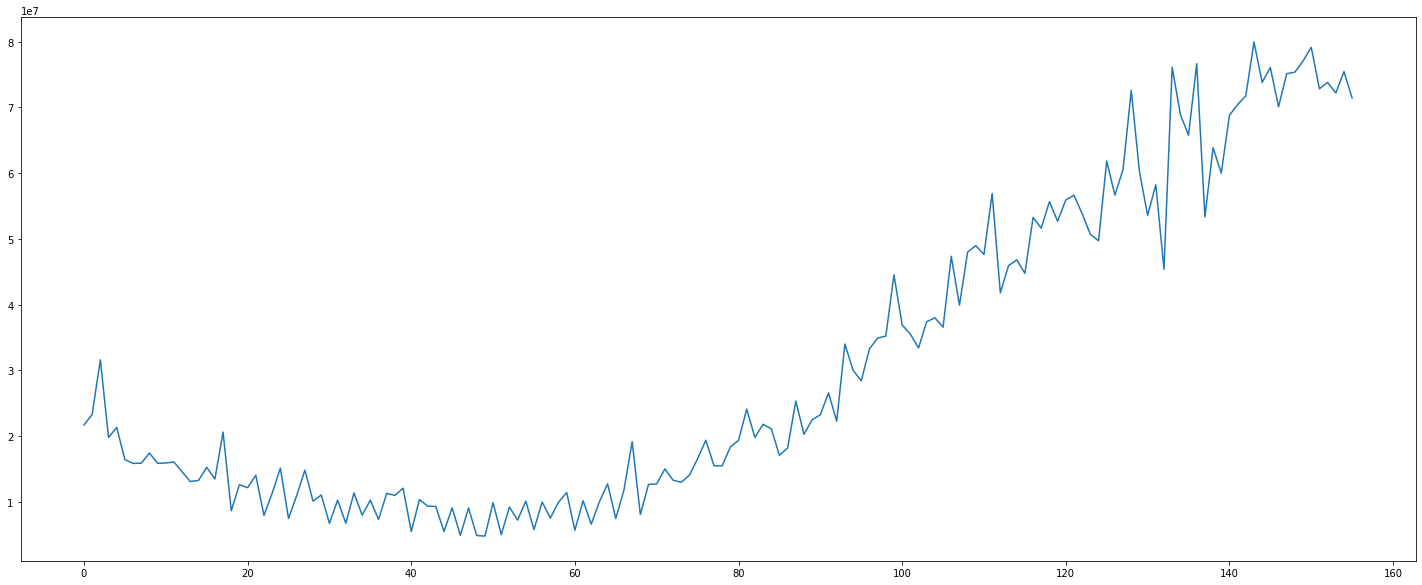

In [37]:
import matplotlib.pyplot as plt
plt.figure(figsize=(25,10))
plt.plot(pd.concat([ct[['UPLINK_THROUGHPUT']][0:144],test]).reset_index(drop=True))
plt.show()

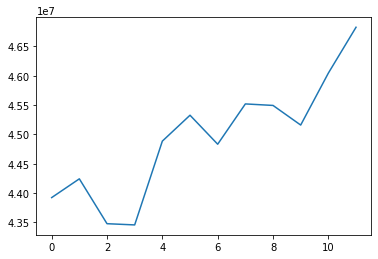

In [55]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(result[0])


In [56]:
result

array([[43922484., 44242412., 43477130., 43456350., 44885770., 45327584.,
        44833080., 45520344., 45494532., 45159868., 46046264., 46828364.]],
      dtype=float32)